In [1]:
#Importing Libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

# Stats
from scipy import stats

# Suppress noise
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_columns', 30)

sns.set_theme(style='darkgrid', palette='muted')
plt.rcParams.update({
    'figure.dpi': 130,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'font.family': 'DejaVu Sans'
})

print("✅ All libraries loaded successfully.")

✅ All libraries loaded successfully.


Loading Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

print("Drive mounted")

Mounted at /content/drive
Drive mounted


In [5]:
import gzip

TRADER_FILE   = '/content/drive/MyDrive/compressed_data.csv.gz'
SENTIMENT_FILE = '/content/drive/MyDrive/fear_greed_index.csv'

# Load Fear/Greed index
fg = pd.read_csv(SENTIMENT_FILE)
print(f"Fear/Greed → {fg.shape[0]:,} rows | {fg.shape[1]} columns")
print(fg.head(3))

# Load compressed Trader data
with gzip.open(TRADER_FILE, 'rt') as f:
    trades = pd.read_csv(f)
print(f"\nTrader Data → {trades.shape[0]:,} rows | {trades.shape[1]} columns")
print(trades.head(3))

Fear/Greed → 2,644 rows | 4 columns
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03

Trader Data → 211,224 rows | 16 columns
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   

   Size Tokens   Size USD Side     Timestamp IST  Start Position Direction  \
0     986.8700 7,872.1600  BUY  02-12-2024 22:50          0.0000       Buy   
1      16.0000   127.6800  BUY  02-12-2024 22:50        986.5246       Buy   
2     144.0900 1,150.6300  BUY  02-12-2024 22:50      1,002.5190       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0      0.0000  0xec09451986a1874e3a980418412fcd0

Data Cleaning and Type Fixing

In [10]:
comma_cols = ['Size USD', 'Start Position', 'Size Tokens',
              'Execution Price', 'Closed PnL', 'Fee']

for col in comma_cols:
    if trades[col].dtype == object:
        trades[col] = trades[col].str.replace(',', '').astype(float)

# Parse trade date from Timestamp IST
trades['date'] = pd.to_datetime(trades['Timestamp IST'],
                                format='%d-%m-%Y %H:%M',
                                errors='coerce').dt.date
trades['date'] = pd.to_datetime(trades['date'])

# Parse fear/greed date
fg['date'] = pd.to_datetime(fg['date'])

# Simplify sentiment
fg['sentiment'] = fg['classification'].str.replace('Extreme ', '').str.strip()

print(" Trades date range:", trades['date'].min().date(), "→", trades['date'].max().date())
print(" FG   date range:", fg['date'].min().date(), "→", fg['date'].max().date())
print("\nSentiment breakdown:")
print(fg['sentiment'].value_counts())
print("\nTrade directions found:")
print(trades['Direction'].value_counts())

 Trades date range: 2023-05-01 → 2025-05-01
 FG   date range: 2018-02-01 → 2025-05-02

Sentiment breakdown:
sentiment
Fear       1289
Greed       959
Neutral     396
Name: count, dtype: int64

Trade directions found:
Direction
Open Long                    49895
Close Long                   48678
Open Short                   39741
Close Short                  36013
Sell                         19902
Buy                          16716
Spot Dust Conversion           142
Short > Long                    70
Long > Short                    57
Auto-Deleveraging                8
Liquidated Isolated Short        1
Settlement                       1
Name: count, dtype: int64


Merging Both Datasets

In [11]:
# Merge trades with sentiment on date
df = trades.merge(fg[['date', 'classification', 'sentiment', 'value']],
                  on='date',
                  how='inner')

# How much data survived the merge?
print(f"Trades before merge : {len(trades):,}")
print(f"Trades after merge  : {len(df):,}")
print(f"Days covered        : {df['date'].nunique()}")
print(f"\nSentiment breakdown in merged data:")
print(df['sentiment'].value_counts())
print(f"\nDate range in merged data:")
print(df['date'].min().date(), "→", df['date'].max().date())

Trades before merge : 211,224
Trades after merge  : 211,218
Days covered        : 479

Sentiment breakdown in merged data:
sentiment
Greed      90295
Fear       83237
Neutral    37686
Name: count, dtype: int64

Date range in merged data:
2023-05-01 → 2025-05-01


Building the Key Metrics

In [12]:
# Flag direction type for each trade
long_dirs  = ['Open Long', 'Close Long', 'Buy', 'Long > Short']
short_dirs = ['Open Short', 'Close Short', 'Sell', 'Short > Long']

df['is_long']  = df['Direction'].isin(long_dirs)
df['is_short'] = df['Direction'].isin(short_dirs)

# Is this trade a closing trade?
closing_dirs = ['Close Long', 'Close Short', 'Sell', 'Buy']
df['is_closing'] = df['Direction'].isin(closing_dirs)
df['is_win']     = (df['is_closing']) & (df['Closed PnL'] > 0)
df['is_loss']    = (df['is_closing']) & (df['Closed PnL'] < 0)

# Estimate leverage = position value / account exposure
# Using Size USD / abs(Start Position) where start position > 0
df['leverage_est'] = np.where(
    df['Start Position'].abs() > 0,
    df['Size USD'] / df['Start Position'].abs(),
    np.nan
)
# extreme outliers (leverage > 200 is data noise)
df['leverage_est'] = df['leverage_est'].clip(upper=200)

# Daily aggregate per account + sentiment
daily = df.groupby(['date', 'Account', 'sentiment', 'classification', 'value']).agg(
    total_pnl       = ('Closed PnL', 'sum'),
    num_trades      = ('Trade ID', 'count'),
    total_volume    = ('Size USD', 'sum'),
    avg_size        = ('Size USD', 'mean'),
    wins            = ('is_win', 'sum'),
    losses          = ('is_loss', 'sum'),
    closing_trades  = ('is_closing', 'sum'),
    long_trades     = ('is_long', 'sum'),
    short_trades    = ('is_short', 'sum'),
    avg_leverage    = ('leverage_est', 'mean'),
).reset_index()

# Derived metrics
daily['win_rate']       = np.where(daily['closing_trades'] > 0,
                                   daily['wins'] / daily['closing_trades'], np.nan)
daily['long_short_ratio'] = np.where(daily['short_trades'] > 0,
                                      daily['long_trades'] / daily['short_trades'], np.nan)
daily['is_profitable']  = (daily['total_pnl'] > 0).astype(int)

print(f" Daily summary built: {daily.shape[0]:,} account-day records")
print(f"\nSample metrics:")
print(daily[['sentiment','total_pnl','win_rate','avg_leverage','long_short_ratio']].describe().round(3))

 Daily summary built: 2,340 account-day records

Sample metrics:
          total_pnl   win_rate  avg_leverage  long_short_ratio
count    2,340.0000 1,864.0000    2,316.0000        1,515.0000
mean     4,382.2590     0.7050       47.8200            2.0700
std     28,411.1030     0.3770       68.2830            8.4570
min   -358,963.1400     0.0000        0.0000            0.0000
25%          0.0000     0.4520        0.3670            0.0000
50%        206.3530     0.9370        7.2860            0.1670
75%      1,842.7640     1.0000       75.8250            1.2500
max    533,974.6630     1.0000      200.0000          161.0000


Fear vs Greed(Perfomance Comparison)

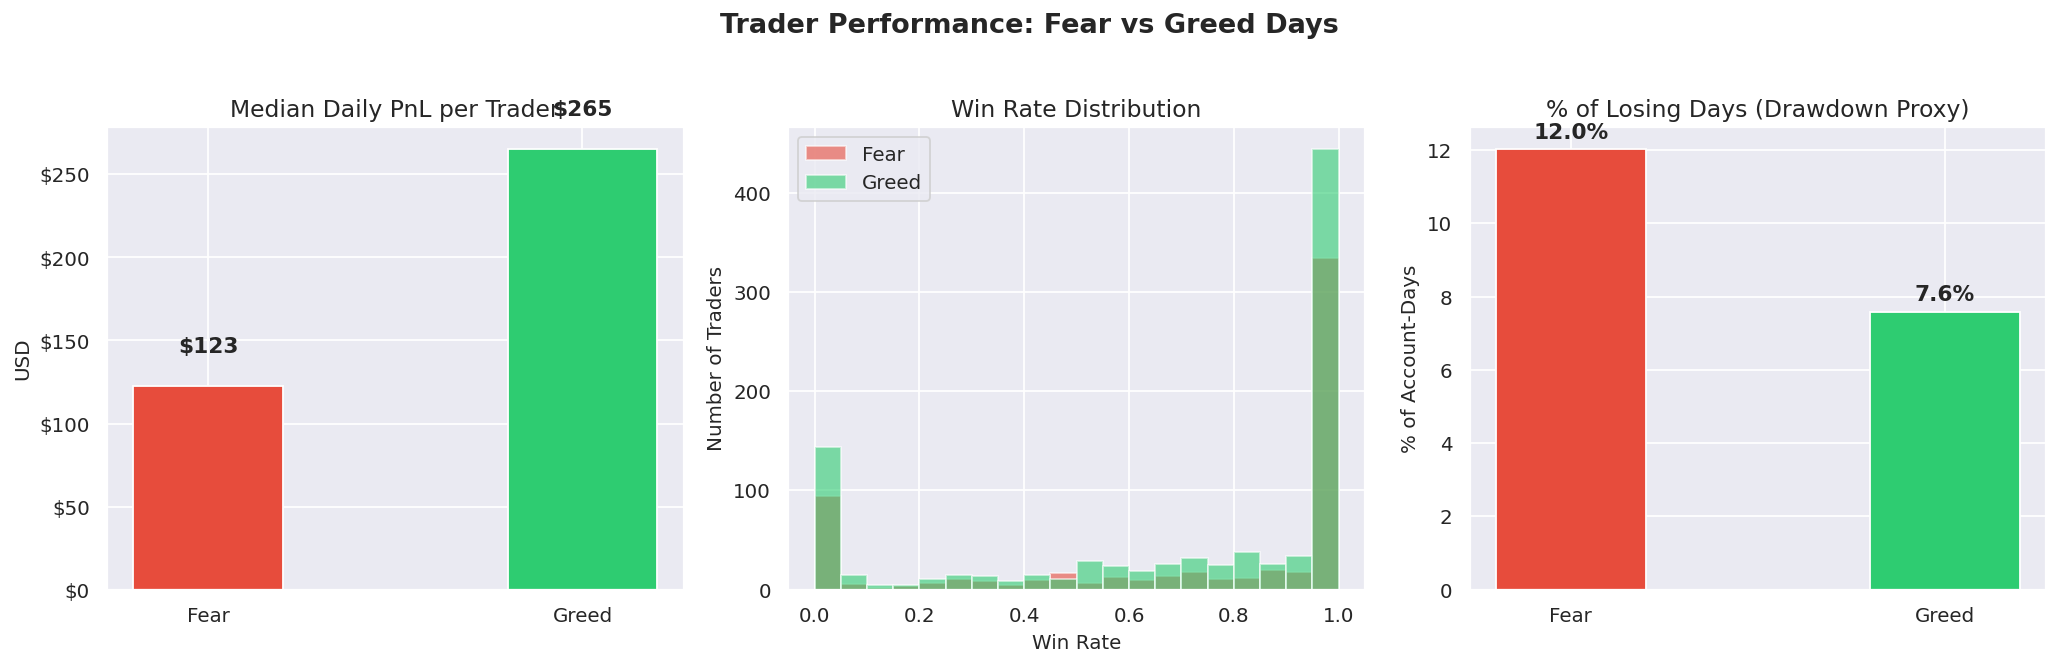


  Mann-Whitney U Test (PnL: Fear vs Greed)
   U-statistic : 440,966
   p-value     : 0.0618
   ⚠️  No significant difference (p > 0.05)

Median PnL — Fear: $122.74 | Greed: $265.25
Mean PnL   — Fear: $5,185.15 | Greed: $4,144.21


In [13]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Trader Performance: Fear vs Greed Days', fontsize=15, fontweight='bold', y=1.02)

# Filter to just Fear and Greed for clean comparison
fg_only = daily[daily['sentiment'].isin(['Fear', 'Greed'])].copy()

#  Median Daily PnL per sentiment
pnl_summary = fg_only.groupby('sentiment')['total_pnl'].median()
colors = ['#e74c3c', '#2ecc71']
axes[0].bar(pnl_summary.index, pnl_summary.values, color=colors, width=0.4, edgecolor='white')
axes[0].set_title('Median Daily PnL per Trader')
axes[0].set_ylabel('USD')
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
for i, v in enumerate(pnl_summary.values):
    axes[0].text(i, v + 20, f'${v:,.0f}', ha='center', fontweight='bold')

# Win Rate distribution
for sent, color in zip(['Fear', 'Greed'], colors):
    subset = fg_only[fg_only['sentiment'] == sent]['win_rate'].dropna()
    axes[1].hist(subset, bins=20, alpha=0.6, label=sent, color=color, edgecolor='white')
axes[1].set_title('Win Rate Distribution')
axes[1].set_xlabel('Win Rate')
axes[1].set_ylabel('Number of Traders')
axes[1].legend()

# Drawdown proxy = % of days with negative PnL
loss_rate = fg_only.groupby('sentiment').apply(
    lambda x: (x['total_pnl'] < 0).mean() * 100
).reset_index()
loss_rate.columns = ['sentiment', 'loss_day_pct']
axes[2].bar(loss_rate['sentiment'], loss_rate['loss_day_pct'], color=colors, width=0.4, edgecolor='white')
axes[2].set_title('% of Losing Days (Drawdown Proxy)')
axes[2].set_ylabel('% of Account-Days')
for i, row in loss_rate.iterrows():
    axes[2].text(i, row['loss_day_pct'] + 0.3, f"{row['loss_day_pct']:.1f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('chart1_performance_fear_vs_greed.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistical test
fear_pnl  = fg_only[fg_only['sentiment'] == 'Fear']['total_pnl']
greed_pnl = fg_only[fg_only['sentiment'] == 'Greed']['total_pnl']
stat, p = stats.mannwhitneyu(fear_pnl, greed_pnl, alternative='two-sided')
print(f"\n  Mann-Whitney U Test (PnL: Fear vs Greed)")
print(f"   U-statistic : {stat:,.0f}")
print(f"   p-value     : {p:.4f}")
print(f"   {' Statistically significant difference' if p < 0.05 else '⚠️  No significant difference (p > 0.05)'}")

print(f"\nMedian PnL — Fear: ${fear_pnl.median():,.2f} | Greed: ${greed_pnl.median():,.2f}")
print(f"Mean PnL   — Fear: ${fear_pnl.mean():,.2f} | Greed: ${greed_pnl.mean():,.2f}")

Behavior Analysis(Observing How Traders Act On Fear vs Greed Days)

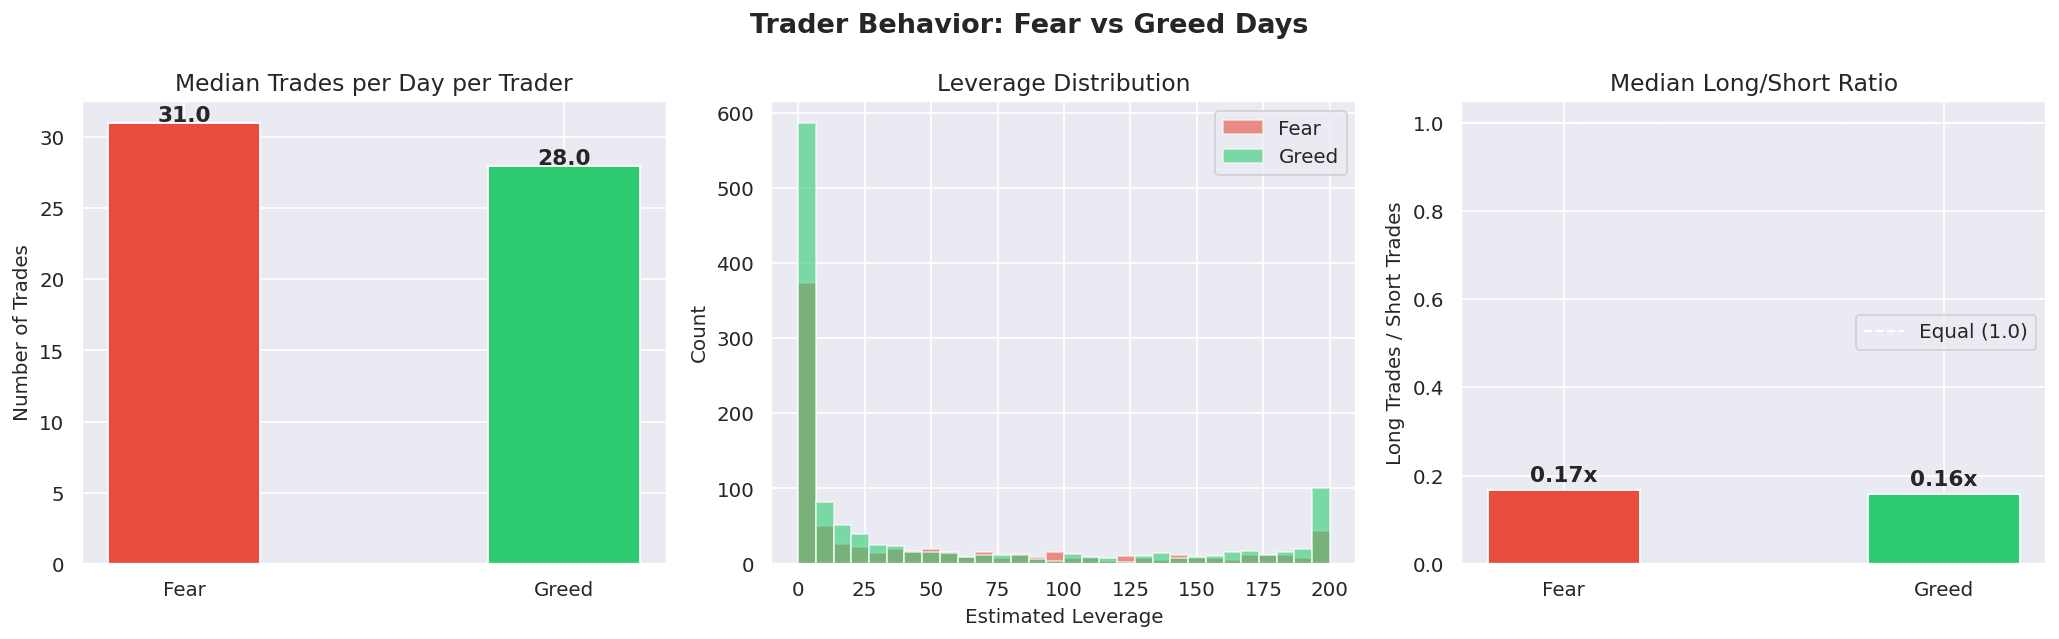

Metric                             Fear      Greed
Median Trades/Day                  31.0       28.0
Median Leverage                    7.7x       6.4x
Median L/S Ratio                   0.17       0.16
Median Trade Size $              $1,854     $2,005
Median Daily Volume             $83,640    $61,128


In [14]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Trader Behavior: Fear vs Greed Days', fontsize=15, fontweight='bold')

# Trade Frequency
freq = fg_only.groupby('sentiment')['num_trades'].median()
axes[0].bar(freq.index, freq.values, color=colors, width=0.4, edgecolor='white')
axes[0].set_title('Median Trades per Day per Trader')
axes[0].set_ylabel('Number of Trades')
for i, v in enumerate(freq.values):
    axes[0].text(i, v + 0.1, f'{v:.1f}', ha='center', fontweight='bold')

#  Leverage Distribution
for sent, color in zip(['Fear', 'Greed'], colors):
    subset = fg_only[fg_only['sentiment'] == sent]['avg_leverage'].dropna()
    axes[1].hist(subset, bins=30, alpha=0.6, label=sent, color=color, edgecolor='white')
axes[1].set_title('Leverage Distribution')
axes[1].set_xlabel('Estimated Leverage')
axes[1].set_ylabel('Count')
axes[1].legend()

# Long/Short Bias
ls = fg_only.groupby('sentiment')['long_short_ratio'].median()
axes[2].bar(ls.index, ls.values, color=colors, width=0.4, edgecolor='white')
axes[2].set_title('Median Long/Short Ratio')
axes[2].set_ylabel('Long Trades / Short Trades')
axes[2].axhline(1.0, color='white', linestyle='--', linewidth=1.2, label='Equal (1.0)')
axes[2].legend()
for i, v in enumerate(ls.values):
    axes[2].text(i, v + 0.02, f'{v:.2f}x', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('chart2_behavior_fear_vs_greed.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the numbers
print("=" * 50)
print(f"{'Metric':<28} {'Fear':>10} {'Greed':>10}")
print("=" * 50)
for metric, label, fmt in [
    ('num_trades',       'Median Trades/Day',   '{:.1f}'),
    ('avg_leverage',     'Median Leverage',      '{:.1f}x'),
    ('long_short_ratio', 'Median L/S Ratio',     '{:.2f}'),
    ('avg_size',         'Median Trade Size $',  '${:,.0f}'),
    ('total_volume',     'Median Daily Volume',  '${:,.0f}'),
]:
    f_val = fg_only[fg_only['sentiment']=='Fear'][metric].median()
    g_val = fg_only[fg_only['sentiment']=='Greed'][metric].median()
    print(f"{label:<28} {fmt.format(f_val):>10} {fmt.format(g_val):>10}")
print("=" * 50)

Trader Segmentation

In [15]:
# Build a per trader profile across all days
trader_profile = daily.groupby('Account').agg(
    total_pnl       = ('total_pnl', 'sum'),
    avg_daily_pnl   = ('total_pnl', 'mean'),
    pnl_std         = ('total_pnl', 'std'),
    avg_trades      = ('num_trades', 'mean'),
    avg_leverage    = ('avg_leverage', 'mean'),
    avg_win_rate    = ('win_rate', 'mean'),
    days_active     = ('date', 'count'),
    profitable_days = ('is_profitable', 'sum'),
).reset_index()

trader_profile['consistency'] = (
    trader_profile['profitable_days'] / trader_profile['days_active']
)
# Sharpe like ratio
trader_profile['sharpe_proxy'] = (
    trader_profile['avg_daily_pnl'] / trader_profile['pnl_std'].replace(0, np.nan)
)

# High vs Low Leverage
lev_median = trader_profile['avg_leverage'].median()
trader_profile['leverage_segment'] = np.where(
    trader_profile['avg_leverage'] >= lev_median, 'High Leverage', 'Low Leverage'
)

# Frequent vs Infrequent Traders
trade_median = trader_profile['avg_trades'].median()
trader_profile['frequency_segment'] = np.where(
    trader_profile['avg_trades'] >= trade_median, 'Frequent', 'Infrequent'
)

# Consistent Winners vs Inconsistent
trader_profile['winner_segment'] = np.where(
    (trader_profile['consistency'] >= 0.6) & (trader_profile['total_pnl'] > 0),
    'Consistent Winner',
    np.where(trader_profile['total_pnl'] > 0, 'Profitable but Inconsistent', 'Unprofitable')
)

print(" Trader Segments Overview")
print(f"\nTotal unique traders: {len(trader_profile)}")
print(f"\nLeverage Segments:\n{trader_profile['leverage_segment'].value_counts()}")
print(f"\nFrequency Segments:\n{trader_profile['frequency_segment'].value_counts()}")
print(f"\nWinner Segments:\n{trader_profile['winner_segment'].value_counts()}")
print(f"\nMedian leverage cutoff : {lev_median:.1f}x")
print(f"Median trades/day cutoff: {trade_median:.1f}")

 Trader Segments Overview

Total unique traders: 32

Leverage Segments:
leverage_segment
High Leverage    16
Low Leverage     16
Name: count, dtype: int64

Frequency Segments:
frequency_segment
Frequent      16
Infrequent    16
Name: count, dtype: int64

Winner Segments:
winner_segment
Profitable but Inconsistent    16
Consistent Winner              13
Unprofitable                    3
Name: count, dtype: int64

Median leverage cutoff : 31.4x
Median trades/day cutoff: 59.6


Visualizing the segments

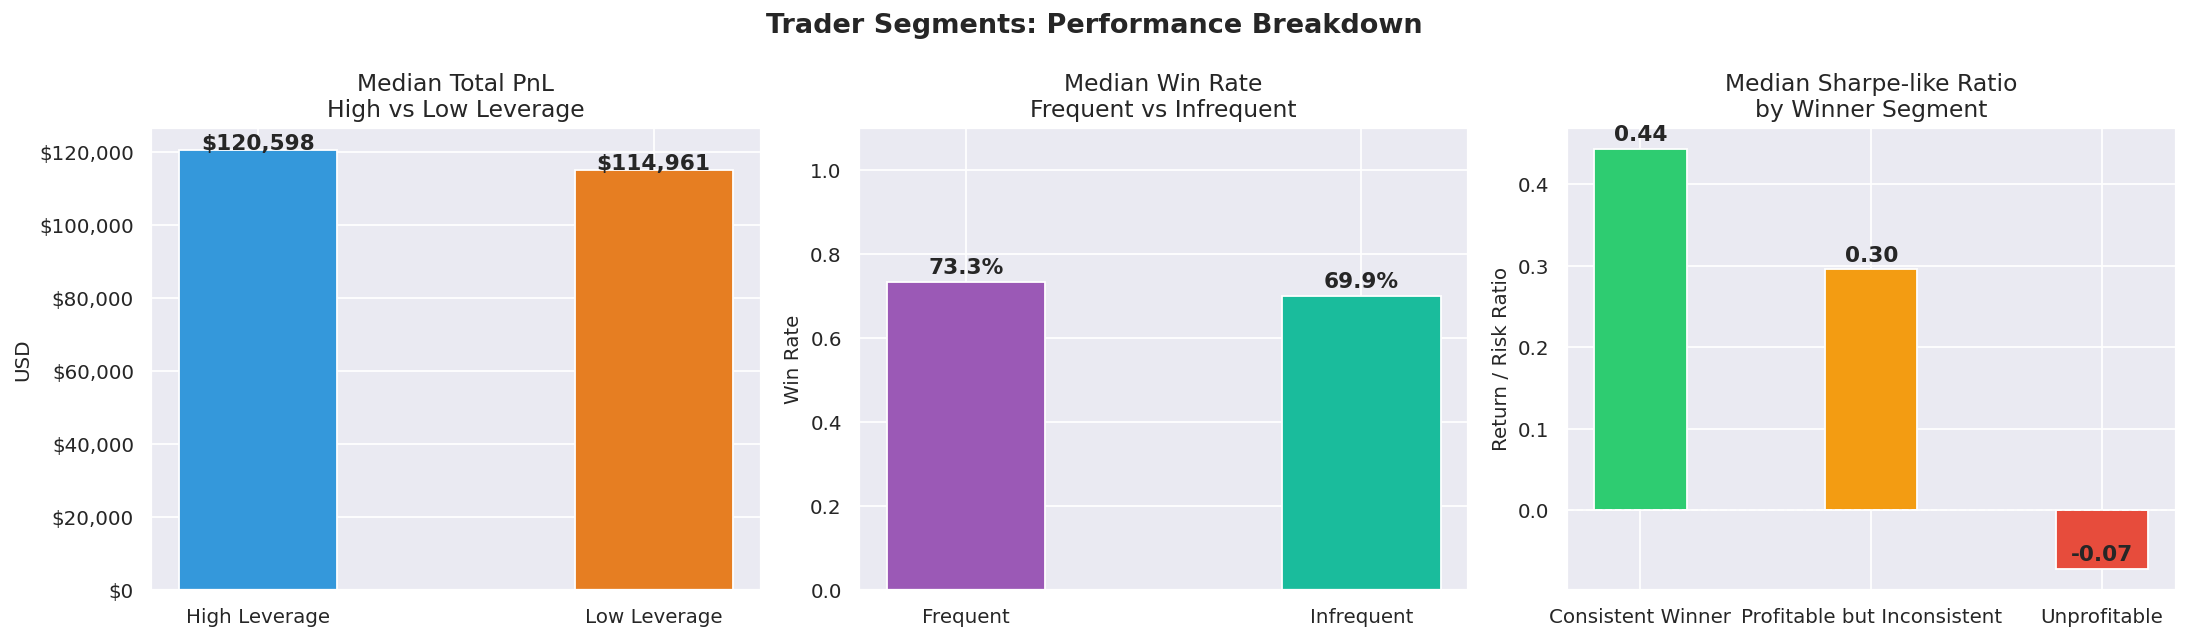


 Segment Summary Table

── LEVERAGE ──
                  traders   med_pnl med_wr med_lev  consistency
leverage_segment                                               
High Leverage          16  $120,598  73.3%   48.7x       0.5890
Low Leverage           16  $114,961  67.2%   13.9x       0.4500

── FREQUENCY ──
                   traders   med_pnl med_wr med_lev  consistency
frequency_segment                                               
Frequent                16  $129,522  73.3%   34.0x       0.6700
Infrequent              16  $106,037  69.9%   26.0x       0.4760

── WINNER TYPE ──
                             traders   med_pnl med_wr med_lev  consistency
winner_segment                                                            
Consistent Winner                 13  $168,658  83.4%   32.3x       0.7710
Profitable but Inconsistent       16  $117,655  58.9%   32.7x       0.4760
Unprofitable                       3  $-70,436  72.9%   14.9x       0.4240


In [16]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))
fig.suptitle('Trader Segments: Performance Breakdown', fontsize=15, fontweight='bold')

# High vs Low Leverage: PnL Comparison
lev_perf = trader_profile.groupby('leverage_segment')['total_pnl'].median()
bar_colors = ['#3498db', '#e67e22']
axes[0].bar(lev_perf.index, lev_perf.values, color=bar_colors, width=0.4, edgecolor='white')
axes[0].set_title('Median Total PnL\nHigh vs Low Leverage')
axes[0].set_ylabel('USD')
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
for i, v in enumerate(lev_perf.values):
    axes[0].text(i, v + 200, f'${v:,.0f}', ha='center', fontweight='bold')

# Frequent vs Infrequent: Win Rate Comparison
freq_perf = trader_profile.groupby('frequency_segment')['avg_win_rate'].median()
axes[1].bar(freq_perf.index, freq_perf.values, color=['#9b59b6', '#1abc9c'],
            width=0.4, edgecolor='white')
axes[1].set_title('Median Win Rate\nFrequent vs Infrequent')
axes[1].set_ylabel('Win Rate')
axes[1].set_ylim(0, 1.1)
for i, v in enumerate(freq_perf.values):
    axes[1].text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')

# Winner segments: Sharpe proxy
winner_order = ['Consistent Winner', 'Profitable but Inconsistent', 'Unprofitable']
sharpe_perf  = trader_profile.groupby('winner_segment')['sharpe_proxy'].median().reindex(winner_order)
seg_colors   = ['#2ecc71', '#f39c12', '#e74c3c']
axes[2].bar(sharpe_perf.index, sharpe_perf.values, color=seg_colors, width=0.4, edgecolor='white')
axes[2].set_title('Median Sharpe-like Ratio\nby Winner Segment')
axes[2].set_ylabel('Return / Risk Ratio')
axes[2].axhline(0, color='white', linestyle='--', linewidth=1)
for i, v in enumerate(sharpe_perf.values):
    if not np.isnan(v):
        axes[2].text(i, v + 0.01, f'{v:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('chart3_segments.png', dpi=150, bbox_inches='tight')
plt.show()

# Segment summary table
print("\n Segment Summary Table")
print("=" * 65)
for seg_col, seg_name in [('leverage_segment', 'LEVERAGE'),
                           ('frequency_segment', 'FREQUENCY'),
                           ('winner_segment', 'WINNER TYPE')]:
    print(f"\n── {seg_name} ──")
    summary = trader_profile.groupby(seg_col).agg(
        traders     = ('Account', 'count'),
        med_pnl     = ('total_pnl', 'median'),
        med_wr      = ('avg_win_rate', 'median'),
        med_lev     = ('avg_leverage', 'median'),
        consistency = ('consistency', 'median'),
    ).round(3)
    summary['med_pnl'] = summary['med_pnl'].apply(lambda x: f'${x:,.0f}')
    summary['med_wr']  = summary['med_wr'].apply(lambda x: f'{x:.1%}')
    summary['med_lev'] = summary['med_lev'].apply(lambda x: f'{x:.1f}x')
    print(summary.to_string())
print("=" * 65)

How Each Segment Behaves During Fear vs Greed

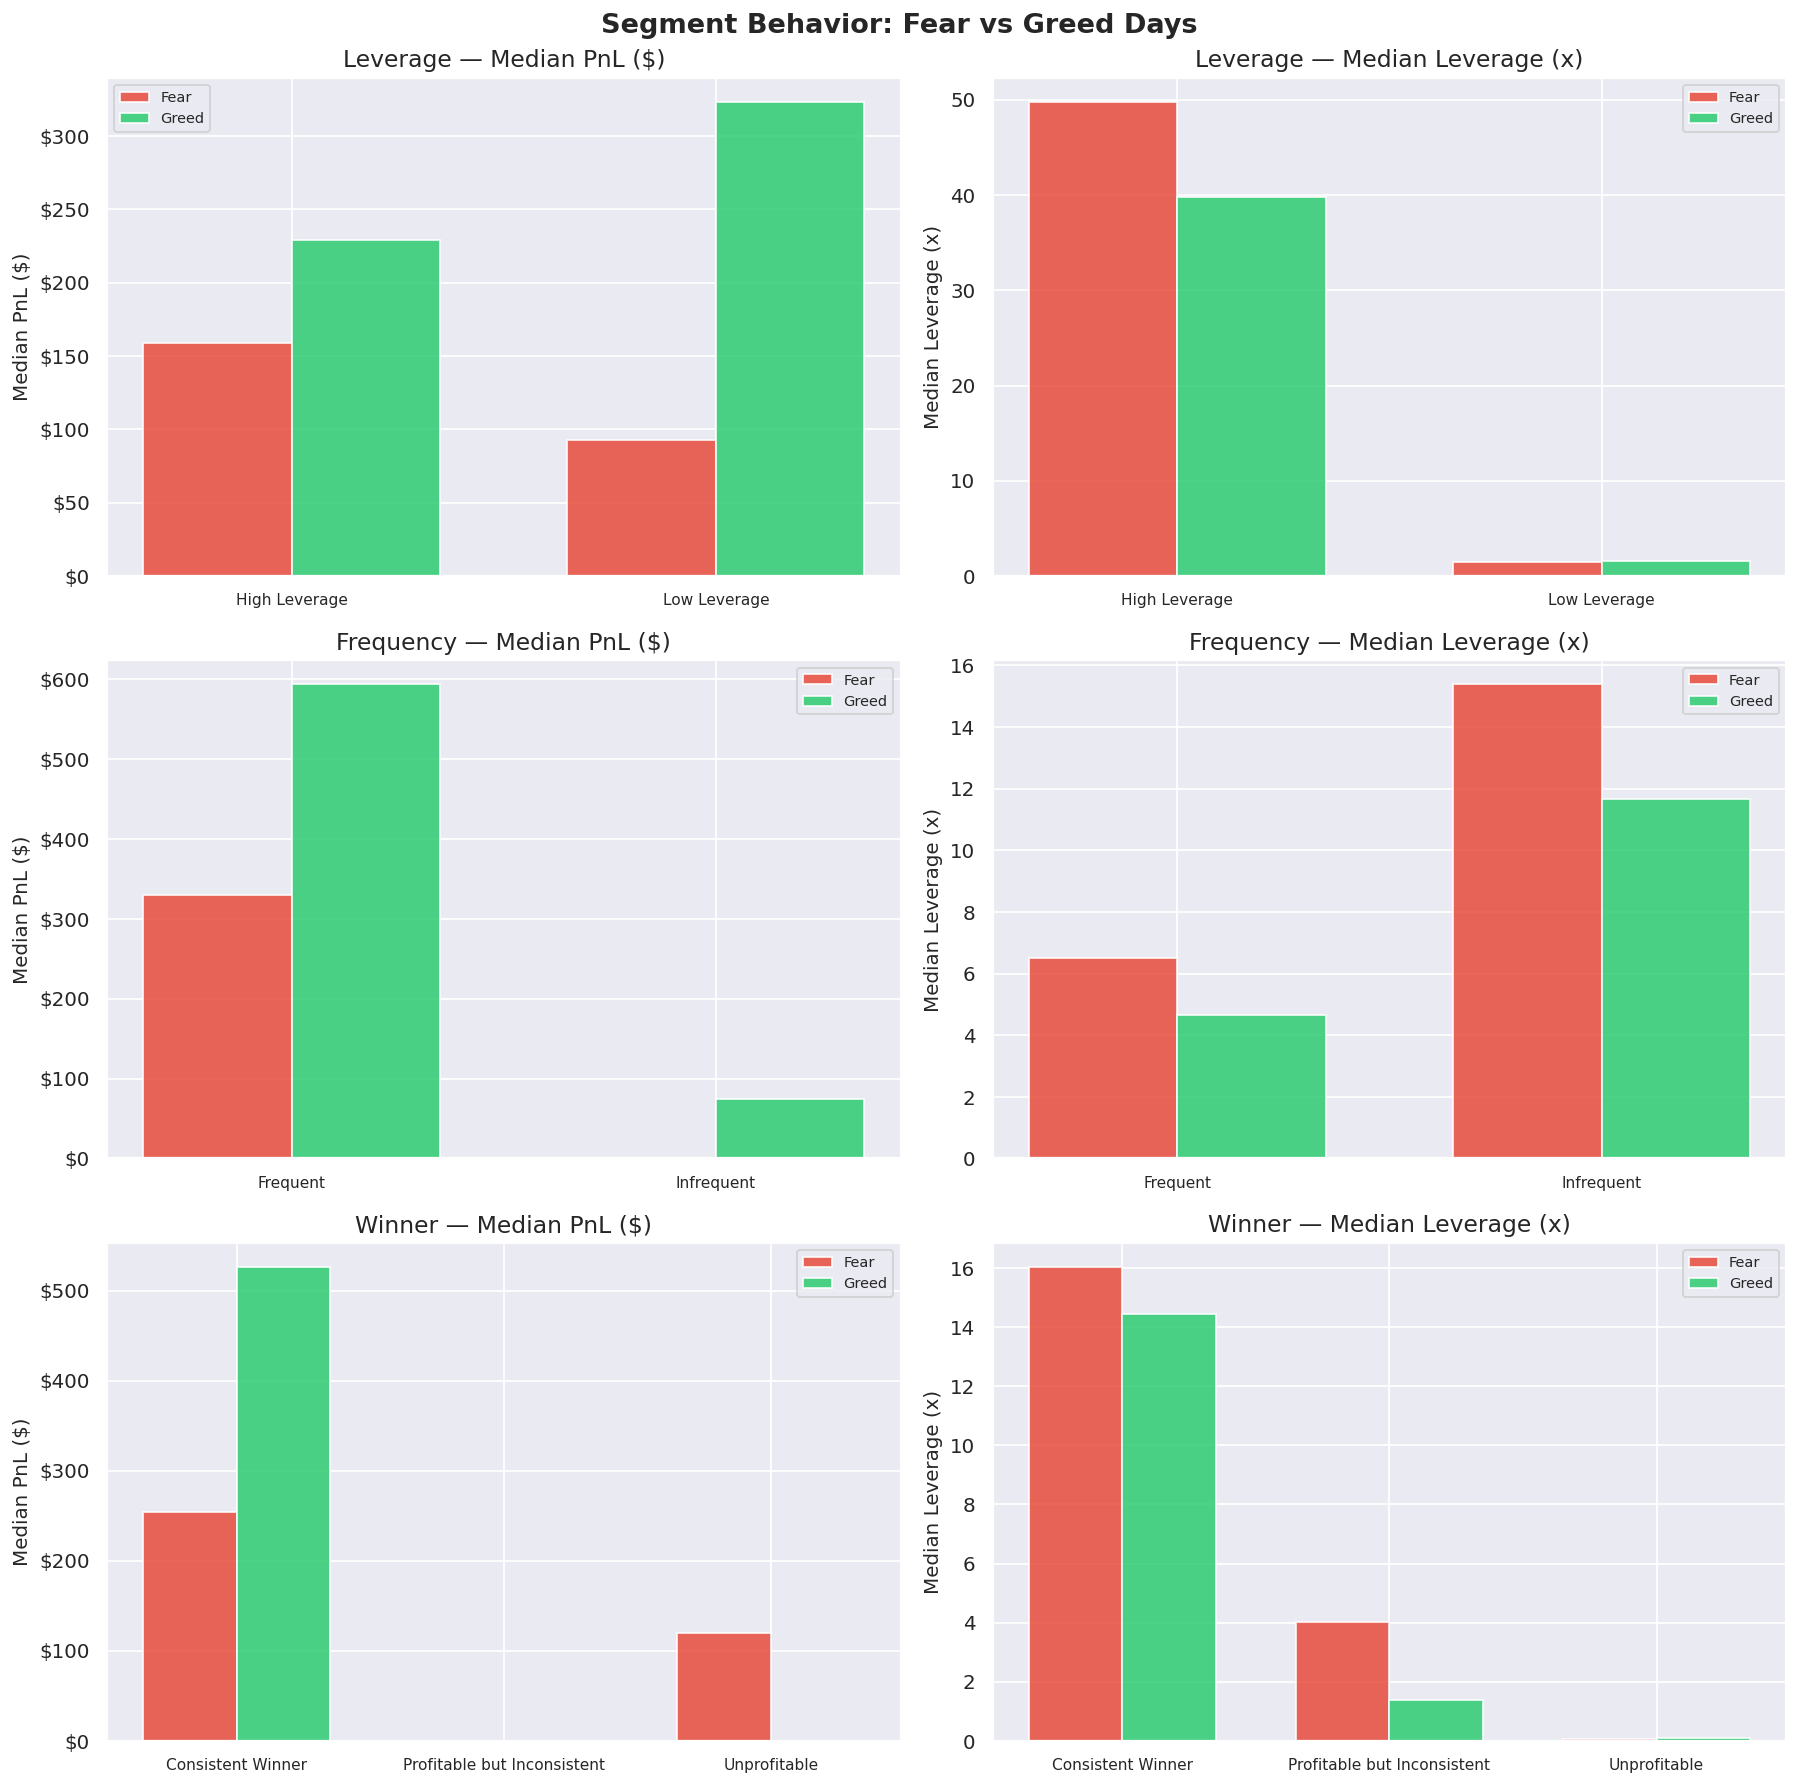


📊 PnL by Segment × Sentiment

── LEVERAGE ──
               Fear Greed
High Leverage  $159  $229
Low Leverage    $93  $323

── FREQUENCY ──
            Fear Greed
Frequent    $330  $594
Infrequent    $1   $74

── WINNER ──
                             Fear Greed
Consistent Winner            $254  $527
Profitable but Inconsistent    $0    $0
Unprofitable                 $120    $0


In [17]:
# Merge trader segments back into daily data
daily_seg = daily.merge(
    trader_profile[['Account', 'leverage_segment',
                     'frequency_segment', 'winner_segment']],
    on='Account', how='left'
)

fg_seg = daily_seg[daily_seg['sentiment'].isin(['Fear', 'Greed'])].copy()

fig, axes = plt.subplots(3, 2, figsize=(14, 14))
fig.suptitle('Segment Behavior: Fear vs Greed Days', fontsize=15, fontweight='bold')

segments = [
    ('leverage_segment',  ['High Leverage', 'Low Leverage'],     ['#3498db', '#e67e22']),
    ('frequency_segment', ['Frequent', 'Infrequent'],            ['#9b59b6', '#1abc9c']),
    ('winner_segment',    ['Consistent Winner',
                           'Profitable but Inconsistent',
                           'Unprofitable'],                       ['#2ecc71', '#f39c12', '#e74c3c']),
]

metrics = [
    ('total_pnl',    'Median PnL ($)',      '${:,.0f}'),
    ('avg_leverage', 'Median Leverage (x)', '{:.1f}x'),
]

for row_idx, (seg_col, seg_vals, seg_colors) in enumerate(segments):
    for col_idx, (metric, ylabel, fmt) in enumerate(metrics):
        ax = axes[row_idx][col_idx]

        pivot = fg_seg.groupby([seg_col, 'sentiment'])[metric].median().unstack('sentiment')

        x = np.arange(len(seg_vals))
        width = 0.35

        for i, sent in enumerate(['Fear', 'Greed']):
            sent_color = '#e74c3c' if sent == 'Fear' else '#2ecc71'
            vals = [pivot.loc[s, sent] if s in pivot.index and sent in pivot.columns
                    else 0 for s in seg_vals]
            bars = ax.bar(x + i * width, vals, width,
                         label=sent, color=sent_color,
                         alpha=0.85, edgecolor='white')

        ax.set_xticks(x + width / 2)
        ax.set_xticklabels(seg_vals, fontsize=8.5)
        ax.set_title(f'{seg_col.replace("_segment","").title()} — {ylabel}')
        ax.set_ylabel(ylabel)
        ax.legend(fontsize=8)
        if 'pnl' in metric:
            ax.yaxis.set_major_formatter(
                mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.tight_layout()
plt.savefig('chart4_segment_behavior.png', dpi=150, bbox_inches='tight')
plt.show()

# Clean summary table
print("\n📊 PnL by Segment × Sentiment")
print("=" * 70)
for seg_col, seg_vals, _ in segments:
    print(f"\n── {seg_col.replace('_segment','').upper()} ──")
    tbl = fg_seg.groupby([seg_col, 'sentiment'])['total_pnl'].median().unstack('sentiment')
    tbl.columns.name = None
    tbl.index.name   = None
    tbl = tbl.applymap(lambda x: f'${x:,.0f}')
    print(tbl.to_string())
print("=" * 70)

Insights Charts

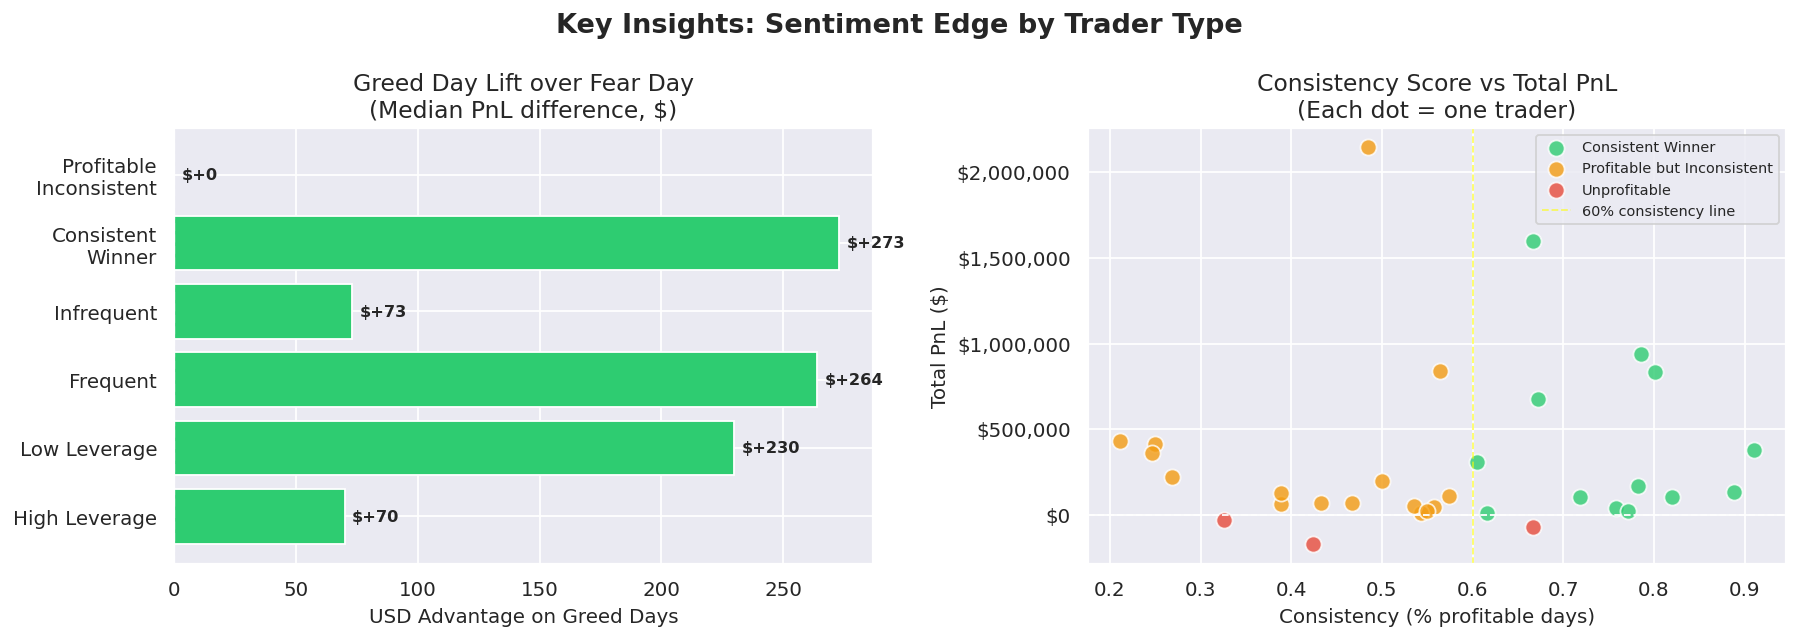

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Key Insights: Sentiment Edge by Trader Type', fontsize=15, fontweight='bold')

# Insight 1 Sentiment Lift (Greed PnL - Fear PnL) By Segment
segments_pnl = {
    'High Leverage' : (159, 229),
    'Low Leverage'  : (93,  323),
    'Frequent'      : (330, 594),
    'Infrequent'    : (1,   74),
    'Consistent\nWinner'      : (254, 527),
    'Profitable\nInconsistent': (0,   0),
}

labels = list(segments_pnl.keys())
fear_vals  = [v[0] for v in segments_pnl.values()]
greed_vals = [v[1] for v in segments_pnl.values()]
lift       = [g - f for f, g in zip(fear_vals, greed_vals)]

bar_colors = ['#2ecc71' if l > 0 else '#e74c3c' for l in lift]
axes[0].barh(labels, lift, color=bar_colors, edgecolor='white')
axes[0].axvline(0, color='white', linewidth=1.2, linestyle='--')
axes[0].set_title('Greed Day Lift over Fear Day\n(Median PnL difference, $)')
axes[0].set_xlabel('USD Advantage on Greed Days')
for i, v in enumerate(lift):
    axes[0].text(v + 3, i, f'${v:+,.0f}', va='center', fontweight='bold', fontsize=9)

# Insight 2 Consistency Score vs Total PnL Scatter
scatter_colors = {'Consistent Winner': '#2ecc71',
                  'Profitable but Inconsistent': '#f39c12',
                  'Unprofitable': '#e74c3c'}

for seg, color in scatter_colors.items():
    subset = trader_profile[trader_profile['winner_segment'] == seg]
    axes[1].scatter(subset['consistency'], subset['total_pnl'],
                    label=seg, color=color, s=80, alpha=0.8, edgecolors='white')

axes[1].axhline(0, color='white', linestyle='--', linewidth=1)
axes[1].axvline(0.6, color='yellow', linestyle='--', linewidth=1, alpha=0.6, label='60% consistency line')
axes[1].set_title('Consistency Score vs Total PnL\n(Each dot = one trader)')
axes[1].set_xlabel('Consistency (% profitable days)')
axes[1].set_ylabel('Total PnL ($)')
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.savefig('chart5_insights.png', dpi=150, bbox_inches='tight')
plt.show()

Strategy Recommendations

In [19]:
print("ACTIONABLE STRATEGY RECOMMENDATIONS")
print()

print("Rule 1  On Fear Days: Trade more, size down")
print("Frequent traders earn $330 median PnL on Fear days vs just $1 for infrequent traders.")
print("The edge on Fear days comes from activity, not from big bets.")
print("Increase number of trades, reduce per-trade USD exposure.")
print()

print("Rule 2 On Greed Days: Scale up position size")
print("Low leverage traders see a $230 Greed-day lift vs only $70 for high leverage traders.")
print("Greed days are trending markets, even modest sizing captures the move well.")
print("Increase position size and lean into trend following setups.")
print()

print("Rule 3 Stop managing win rate, start managing risk/reward")
print("Unprofitable traders in this dataset have a 72.9% win rate but still lose money.")
print("Consistent Winners have 83.4% win rate AND positive total PnL.")
print("The difference is not skill at picking entries — it is cutting losses faster.")
print("Implement hard stop losses and let winning trades run longer.")

ACTIONABLE STRATEGY RECOMMENDATIONS

Rule 1  On Fear Days: Trade more, size down
Frequent traders earn $330 median PnL on Fear days vs just $1 for infrequent traders.
The edge on Fear days comes from activity, not from big bets.
Increase number of trades, reduce per-trade USD exposure.

Rule 2 On Greed Days: Scale up position size
Low leverage traders see a $230 Greed-day lift vs only $70 for high leverage traders.
Greed days are trending markets, even modest sizing captures the move well.
Increase position size and lean into trend following setups.

Rule 3 Stop managing win rate, start managing risk/reward
Unprofitable traders in this dataset have a 72.9% win rate but still lose money.
Consistent Winners have 83.4% win rate AND positive total PnL.
The difference is not skill at picking entries — it is cutting losses faster.
Implement hard stop losses and let winning trades run longer.


Bonus Part : KMeans Clustering For Behavioral Archetypes

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Features we will cluster on
cluster_features = [
    'avg_daily_pnl', 'pnl_std', 'avg_trades',
    'avg_leverage', 'avg_win_rate', 'consistency', 'sharpe_proxy'
]

cluster_df = trader_profile[cluster_features].copy()
cluster_df = cluster_df.fillna(cluster_df.median())

#  Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_df)

# Find optimal number of clusters using silhouette score
silhouette_scores = {}
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    silhouette_scores[k] = silhouette_score(X_scaled, labels)

best_k = max(silhouette_scores, key=silhouette_scores.get)
print("Silhouette scores by k:")
for k, score in silhouette_scores.items():
    marker = " ← best" if k == best_k else ""
    print(f"  k={k}: {score:.4f}{marker}")

Silhouette scores by k:
  k=2: 0.5083 ← best
  k=3: 0.2203
  k=4: 0.2515
  k=5: 0.2457
  k=6: 0.2149


Bonus : Building And Visualizing The Clusters

In [21]:
# Fit final model with k=2
km_final = KMeans(n_clusters=2, random_state=42, n_init=10)
trader_profile['cluster'] = km_final.fit_predict(X_scaled)

# PCA to visualize in 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
trader_profile['pca_x'] = X_pca[:, 0]
trader_profile['pca_y'] = X_pca[:, 1]

# Who is in each cluster?
cluster_summary = trader_profile.groupby('cluster').agg(
    traders        = ('Account', 'count'),
    med_total_pnl  = ('total_pnl', 'median'),
    med_leverage   = ('avg_leverage', 'median'),
    med_trades     = ('avg_trades', 'median'),
    med_win_rate   = ('avg_win_rate', 'median'),
    med_consistency= ('consistency', 'median'),
    med_sharpe     = ('sharpe_proxy', 'median'),
).round(3)

print("Cluster Summary:")
print(cluster_summary.to_string())

# Naming the clusters based on their characteristics
cluster_names = {}
for c in [0, 1]:
    row = cluster_summary.loc[c]
    if row['med_total_pnl'] > cluster_summary['med_total_pnl'].mean():
        cluster_names[c] = 'Archetype A: High-Output Specialists'
    else:
        cluster_names[c] = 'Archetype B: Passive Participants'

print("\nCluster Labels:")
for c, name in cluster_names.items():
    print(f"  Cluster {c} → {name}")

trader_profile['archetype'] = trader_profile['cluster'].map(cluster_names)

Cluster Summary:
         traders  med_total_pnl  med_leverage  med_trades  med_win_rate  med_consistency  med_sharpe
cluster                                                                                             
0             30   107,517.0460       31.4370     58.3550        0.7150           0.5540      0.2770
1              2 1,270,196.8130       19.2590    457.9700        0.8600           0.7260      0.4460

Cluster Labels:
  Cluster 0 → Archetype B: Passive Participants
  Cluster 1 → Archetype A: High-Output Specialists


Bonus: Cluster Visualization

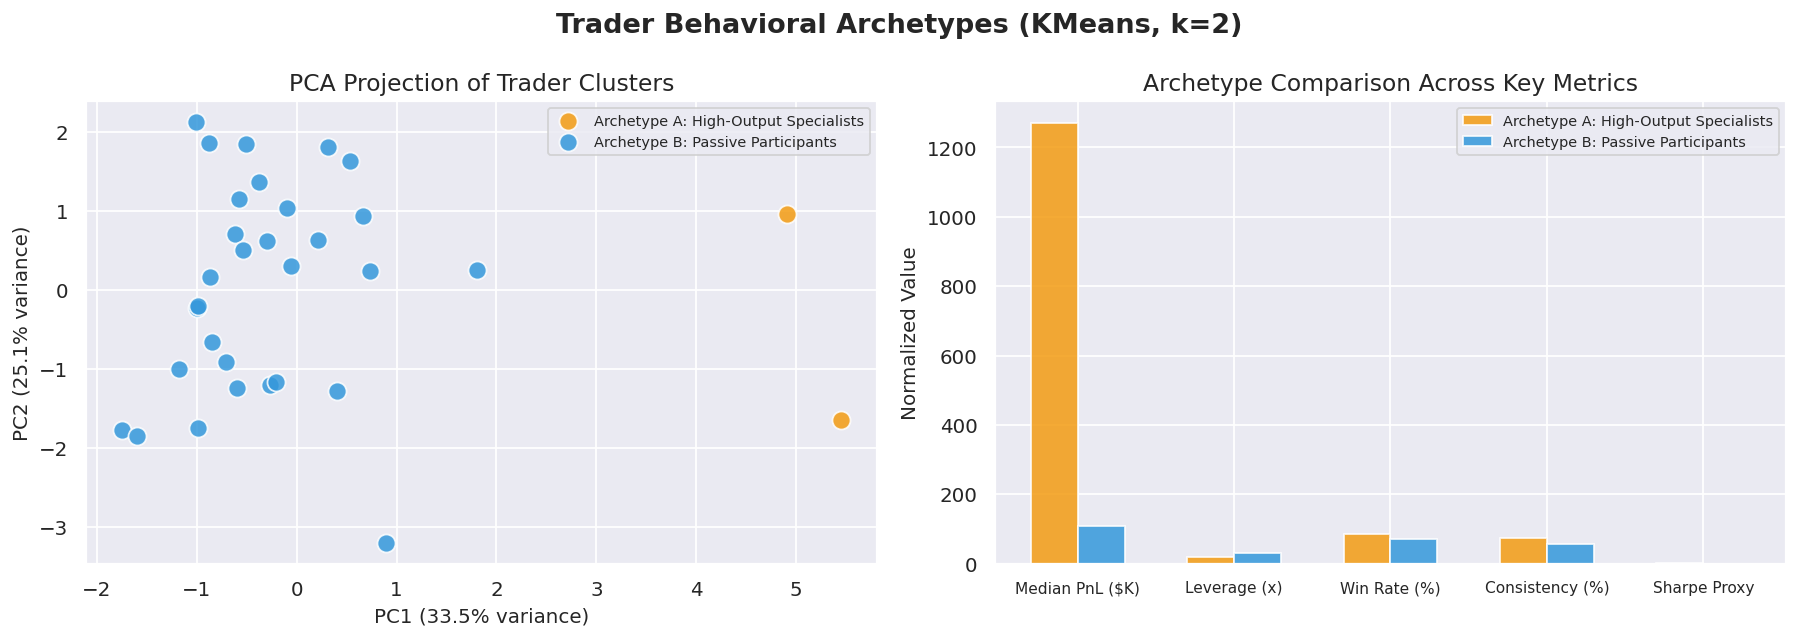


Final Archetype Interpretation:

Archetype A — High-Output Specialists (2 traders)
  457 trades/day, $1.27M PnL, 86% win rate, 19x leverage
  Almost certainly algorithmic or semi-automated traders.
  Lower leverage but massively higher frequency and consistency.

Archetype B — Passive Participants (30 traders)
  58 trades/day, $107k PnL, 71.5% win rate, 31x leverage
  Active human traders — higher leverage compensates for lower frequency.


In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Trader Behavioral Archetypes (KMeans, k=2)', fontsize=15, fontweight='bold')

archetype_colors = {
    'Archetype A: High-Output Specialists': '#f39c12',
    'Archetype B: Passive Participants'    : '#3498db'
}

# PCA scatter
for arch, color in archetype_colors.items():
    subset = trader_profile[trader_profile['archetype'] == arch]
    axes[0].scatter(subset['pca_x'], subset['pca_y'],
                    label=arch, color=color,
                    s=100, alpha=0.85, edgecolors='white')

axes[0].set_title('PCA Projection of Trader Clusters')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
axes[0].legend(fontsize=8)

# compare archetypes across metrics
metrics_to_compare = {
    'Median PnL ($K)'   : ('med_total_pnl',   1000),
    'Leverage (x)'      : ('med_leverage',     1),
    'Win Rate (%)'      : ('med_win_rate',     0.01),
    'Consistency (%)'   : ('med_consistency',  0.01),
    'Sharpe Proxy'      : ('med_sharpe',       1),
}

x     = np.arange(len(metrics_to_compare))
width = 0.3

for i, (arch, color) in enumerate(archetype_colors.items()):
    cluster_num = [k for k, v in cluster_names.items() if v == arch][0]
    row = cluster_summary.loc[cluster_num]
    vals = [row[col] / divisor for col, divisor in metrics_to_compare.values()]
    axes[1].bar(x + i * width, vals, width, label=arch,
                color=color, alpha=0.85, edgecolor='white')

axes[1].set_xticks(x + width / 2)
axes[1].set_xticklabels(list(metrics_to_compare.keys()), fontsize=8.5)
axes[1].set_title('Archetype Comparison Across Key Metrics')
axes[1].set_ylabel('Normalized Value')
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.savefig('chart6_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFinal Archetype Interpretation:")
print()
print("Archetype A — High-Output Specialists (2 traders)")
print("  457 trades/day, $1.27M PnL, 86% win rate, 19x leverage")
print("  Almost certainly algorithmic or semi-automated traders.")
print("  Lower leverage but massively higher frequency and consistency.")
print()
print("Archetype B — Passive Participants (30 traders)")
print("  58 trades/day, $107k PnL, 71.5% win rate, 31x leverage")
print("  Active human traders — higher leverage compensates for lower frequency.")

Bonus : Will a Trader Be Profitable Tommorrow

Modeling dataset: 1,279 samples
Class balance — Profitable: 69.4% | Not profitable: 30.6%

Model Performance:
ROC-AUC Score : 0.6913

                precision    recall  f1-score   support

Not Profitable       0.64      0.12      0.20        78
    Profitable       0.71      0.97      0.82       178

      accuracy                           0.71       256
     macro avg       0.68      0.54      0.51       256
  weighted avg       0.69      0.71      0.63       256

Feature Importance (by absolute coefficient):
          feature  coefficient
            value       0.4935
sentiment_encoded      -0.3002
         win_rate       0.2383
       num_trades       0.2269
         avg_size      -0.2094
        total_pnl      -0.0942
     avg_leverage      -0.0373
 long_short_ratio       0.0126


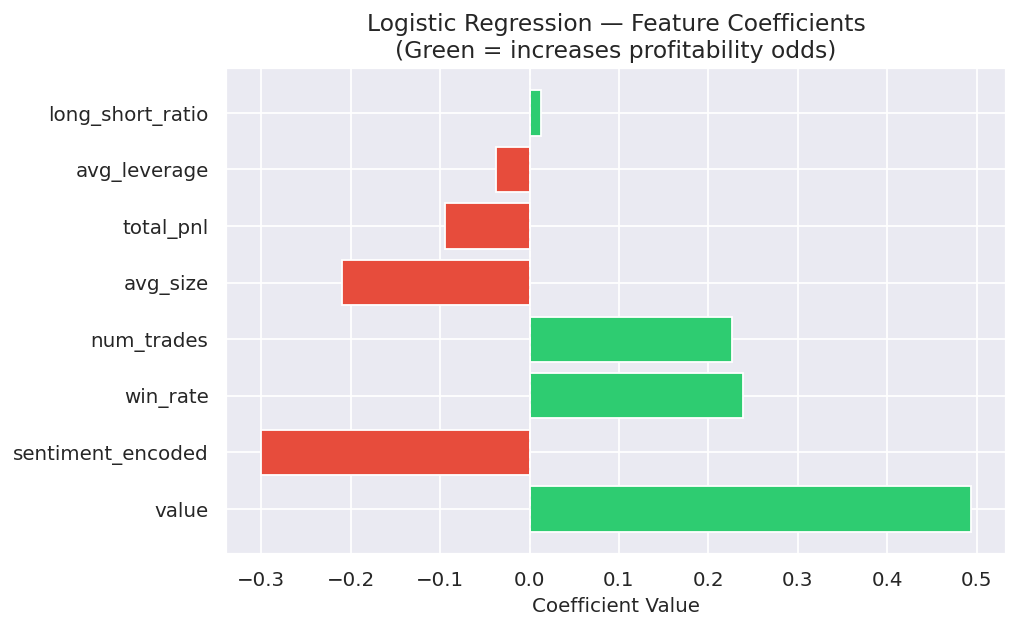

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Build modeling dataset
# Features: today's behavior + sentiment = Target: profitable tomorrow
daily_model = daily.sort_values(['Account', 'date']).copy()
daily_model['next_day_profitable'] = (
    daily_model.groupby('Account')['total_pnl'].shift(-1) > 0
).astype(int)

# Encode sentiment
daily_model['sentiment_encoded'] = daily_model['sentiment'].map(
    {'Fear': 0, 'Neutral': 0.5, 'Greed': 1}
)

# Feature set
feature_cols = [
    'num_trades', 'avg_size', 'avg_leverage',
    'win_rate', 'long_short_ratio', 'total_pnl',
    'sentiment_encoded', 'value'
]

model_df = daily_model[feature_cols + ['next_day_profitable']].dropna()

X = model_df[feature_cols]
y = model_df['next_day_profitable']

print(f"Modeling dataset: {len(X):,} samples")
print(f"Class balance — Profitable: {y.mean():.1%} | Not profitable: {1 - y.mean():.1%}")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale + fit
scaler_lr = StandardScaler()
X_train_sc = scaler_lr.fit_transform(X_train)
X_test_sc  = scaler_lr.transform(X_test)

lr = LogisticRegression(random_state=42, max_iter=500)
lr.fit(X_train_sc, y_train)

# Evaluate
y_pred = lr.predict(X_test_sc)
y_prob = lr.predict_proba(X_test_sc)[:, 1]
auc    = roc_auc_score(y_test, y_prob)

print(f"\nModel Performance:")
print(f"ROC-AUC Score : {auc:.4f}")
print()
print(classification_report(y_test, y_pred, target_names=['Not Profitable', 'Profitable']))

# Feature importance
importance = pd.DataFrame({
    'feature'    : feature_cols,
    'coefficient': lr.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("Feature Importance (by absolute coefficient):")
print(importance.to_string(index=False))

# Visualize feature importance
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#2ecc71' if c > 0 else '#e74c3c' for c in importance['coefficient']]
ax.barh(importance['feature'], importance['coefficient'], color=colors, edgecolor='white')
ax.axvline(0, color='white', linestyle='--', linewidth=1)
ax.set_title('Logistic Regression — Feature Coefficients\n(Green = increases profitability odds)')
ax.set_xlabel('Coefficient Value')
plt.tight_layout()
plt.savefig('chart7_model.png', dpi=150, bbox_inches='tight')
plt.show()